<a href="https://colab.research.google.com/github/rokmr/Computer-Vision/blob/main/src/colab/NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
!wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl

--2025-05-16 05:01:40--  https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
Resolving fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)... 3.5.24.127, 52.216.136.139, 16.182.108.105, ...
Connecting to fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)|3.5.24.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152000164 (1.1G) [binary/octet-stream]
Saving to: ‘testing_data.pkl’

testing_data.pkl    100%[===================>]   1.07G  16.1MB/s    in 73s     

2025-05-16 05:02:54 (15.1 MB/s) - ‘testing_data.pkl’ saved [1152000164/1152000164]

--2025-05-16 05:02:54--  https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl
Resolving fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)... 52.216.42.129, 52.217.142.113, 52.217.126.17, ...
Connecting to fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)|52.216.4

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Piece-wise Constant Transmittance Equation
<div>
<img src='https://raw.githubusercontent.com/rokmr/Computer-Vision/refs/heads/main/assets/transmittance.png'>
</div>

Here, $\delta_k$ is constant for as the ray are uniformly breakdown.

$\sigma_k$ is constant for the piece-wise segment.

$\alpha_k = 1 - exp(-\sigma_k \delta_k)$

$exp(-\sigma_k \delta_k) = 1 - \alpha_k$

$T_n = exp(\sum_{k=1}^{n-1} -\sigma_k \delta_k) = \prod_{k=1}^{n-1} exp( -\sigma_k \delta_k) = \prod_{k=1}^{n-1} (1 - \alpha_k)$

In [ ]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(1 - alphas, dim=1)
    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device)
    return torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1) # Making first element of each series as 1 and leaving out the last element of cumprod

# NeRF Architecture
<div>
<img src='https://raw.githubusercontent.com/rokmr/Computer-Vision/refs/heads/main/assets/NeRFModel.png'>
</div>

In [ ]:
class NeRFModel(nn.Module):
    def __init__(self, embedding_dim_pos=6, embedding_dim_direction=4, hidden_dim=256):
        super(NeRFModel, self).__init__()

        input_dim_block1 = embedding_dim_pos * 6 + 3
        layer_activation = nn.ReLU()

        self.block1 = nn.Sequential(nn.Linear(input_dim_block1, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation)

        # density estimation
        input_dim_block2 = embedding_dim_pos * 6 + hidden_dim + 3

        self.block2 = nn.Sequential(nn.Linear(input_dim_block2, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim + 1))

        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )

        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6 + 3]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6 + 3]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]

        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]

        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]

        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]

        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

# Ray Equation
$$r = o + td$$

<div>
<img src='https://raw.githubusercontent.com/rokmr/Computer-Vision/refs/heads/main/assets/renderingEquation.png'>
</div>

In [ ]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):

    # ray_origins : torch.Size([8192, 3]) || ray_directions : torch.Size([8192, 3])

    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins).to(device) # [32]

    # Compute the 3D points along each ray
    t = t.unsqueeze(dim=0).unsqueeze(2) # [1, 32, 1]
    r = ray_origins.unsqueeze(1) + t * ray_directions.unsqueeze(1)  # [batch_size, nb_bins, 3]

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) # [batch_size, nb_bins, 3]


    colors, sigma = nerf_model(r.reshape(-1, 3), ray_directions.reshape(-1, 3)) # x : [batch_size * nb_bins, 3], ray_directions : [batch_size * nb_bins, 3]
    colors = colors.reshape(r.shape)  # [batch_size, nb_bins, 3]
    sigma = sigma.reshape(r.shape[:-1])  # [batch_size, nb_bins]

    alpha = 1 - torch.exp(-sigma*(hf-hn)/nb_bins)  # [batch_size, nb_bins]

    weights = compute_accumulated_transmittance(alpha) * alpha

    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights.unsqueeze(2) * colors).sum(dim=1)

    weight_sum = weights.sum(-1)  # Regularization for white background

    return c + 1 - weight_sum.unsqueeze(-1)

In [ ]:
def train(nerf_model, optimizer, scheduler, data_loader, testing_dataset, device='cpu', hn=0, hf=1, nb_epochs=int(1e5),
          nb_bins=192, H=400, W=400):
    training_loss = []
    test_images = []

    for epoch in tqdm(range(nb_epochs)):
        # Training loop
        nerf_model.train()
        for batch in data_loader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)

            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            print(f"Loss: {loss.item():.4f}")

        scheduler.step()
        img_index = 0
        img = test(nerf_model, testing_dataset, img_index, hn, hf, nb_bins, device, H=400, W=400)
        test_images.append(img)
        plt.figure()
        plt.imshow(img)
        plt.title(f'Epoch {epoch}')
        plt.show()
        plt.close()

    return training_loss, test_images


def test(nerf_model, testing_dataset, img_index, hn, hf, nb_bins, device, H=400, W=400):
        # Testing/Validation loop
        nerf_model.eval()
        with torch.no_grad():  # Changed from torch.inference_mode
            chunk_size = 10
            ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
            ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

            data = []
            for i in range(int(np.ceil(H * W / (W * chunk_size)))):  # Corrected iteration calculation
                # Get chunk of rays
                start_idx = W * chunk_size * i
                end_idx = min(W * chunk_size * (i + 1), H * W)  # Added min to prevent index out of bounds

                ray_origins_ = ray_origins[start_idx:end_idx].to(device)
                ray_directions_ = ray_directions[start_idx:end_idx].to(device)

                regenerated_px_values = render_rays(nerf_model, ray_origins_, ray_directions_,
                                                 hn=hn, hf=hf, nb_bins=nb_bins)
                data.append(regenerated_px_values.cpu())  # Move to CPU before appending

            img = torch.cat(data).numpy().reshape(H, W, 3)
            return img


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 2963.6553
Loss: 3907.1133
Loss: 2426.9956
Loss: 2252.8462
Loss: 2200.3040
Loss: 2177.6086
Loss: 2175.8389
Loss: 2117.1948
Loss: 2023.7716
Loss: 2029.8325
Loss: 1968.2985
Loss: 1919.4224
Loss: 1819.3491
Loss: 1644.1027
Loss: 1505.2069
Loss: 1245.4968
Loss: 1079.4298
Loss: 1100.8167
Loss: 1374.4381
Loss: 1022.4329
Loss: 1034.4889
Loss: 984.6760
Loss: 980.9753
Loss: 893.4738
Loss: 847.4643
Loss: 868.2524
Loss: 787.0797
Loss: 774.9765
Loss: 786.3959
Loss: 764.5209
Loss: 770.5884
Loss: 712.4927
Loss: 696.1844
Loss: 663.4537
Loss: 651.6993
Loss: 655.0846
Loss: 663.7233
Loss: 625.2546
Loss: 619.4675
Loss: 578.2404
Loss: 594.2501
Loss: 590.8317
Loss: 548.9592
Loss: 534.3755
Loss: 550.4037
Loss: 553.3484
Loss: 525.4322
Loss: 516.9847
Loss: 520.3418
Loss: 517.5132
Loss: 481.5605
Loss: 476.3356
Loss: 471.6922
Loss: 459.6846
Loss: 483.4177
Loss: 463.6965
Loss: 440.5504
Loss: 446.0213
Loss: 435.9342
Loss: 449.9575
Loss: 416.5283
Loss: 423.9779
Loss: 405.9560
Loss: 441.3626
Loss: 420.7017
Loss

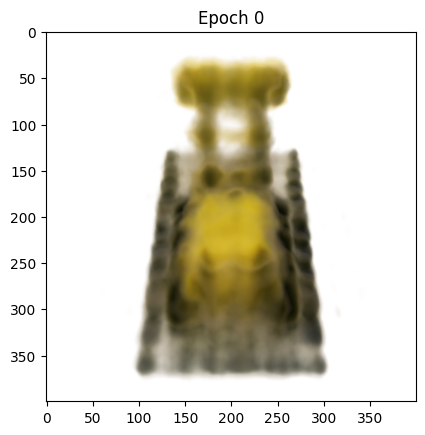

 10%|█         | 1/10 [00:38<05:43, 38.21s/it]

Loss: 317.0358
Loss: 293.5412
Loss: 301.3481
Loss: 301.5635
Loss: 296.0634
Loss: 293.1584
Loss: 310.2921
Loss: 302.7101
Loss: 282.0021
Loss: 305.3780
Loss: 313.6189
Loss: 275.0488
Loss: 309.2549
Loss: 303.5848
Loss: 292.0192
Loss: 292.2145
Loss: 290.9043
Loss: 288.4666
Loss: 291.6156
Loss: 275.9417
Loss: 279.7155
Loss: 285.8978
Loss: 288.1653
Loss: 255.5115
Loss: 288.3177
Loss: 284.5303
Loss: 278.8967
Loss: 292.4148
Loss: 272.4943
Loss: 309.0732
Loss: 298.8432
Loss: 273.1566
Loss: 281.5627
Loss: 275.2270
Loss: 266.4454
Loss: 278.6306
Loss: 267.4001
Loss: 275.0856
Loss: 302.2699
Loss: 287.4646
Loss: 266.9774
Loss: 288.0456
Loss: 278.6377
Loss: 262.2175
Loss: 267.7014
Loss: 265.9286
Loss: 267.3365
Loss: 280.4828
Loss: 247.7610
Loss: 267.4804
Loss: 263.0730
Loss: 279.2261
Loss: 251.4317
Loss: 262.5849
Loss: 262.1479
Loss: 267.0012
Loss: 260.4620
Loss: 266.7224
Loss: 262.0553
Loss: 276.2613
Loss: 259.5630
Loss: 265.2732
Loss: 258.4235
Loss: 240.7008
Loss: 264.4053
Loss: 254.6819
Loss: 245.

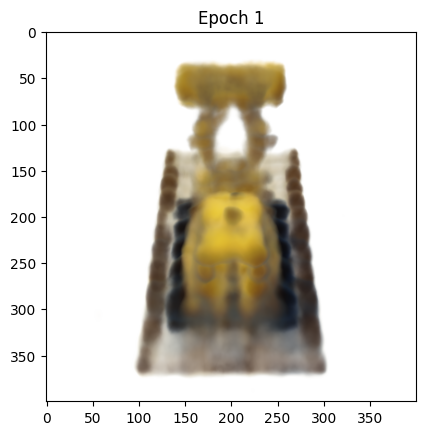

 20%|██        | 2/10 [01:16<05:05, 38.25s/it]

Loss: 244.4867
Loss: 236.9020
Loss: 239.4461
Loss: 221.9876
Loss: 247.4989
Loss: 231.5460
Loss: 225.2430
Loss: 238.5146
Loss: 237.6570
Loss: 235.0424
Loss: 219.0379
Loss: 238.2975
Loss: 228.9478
Loss: 209.8539
Loss: 229.6124
Loss: 212.7147
Loss: 232.2725
Loss: 230.7530
Loss: 224.0410
Loss: 247.4921
Loss: 215.3552
Loss: 214.1884
Loss: 204.0119
Loss: 218.1637
Loss: 212.6077
Loss: 218.8394
Loss: 215.7591
Loss: 212.5658
Loss: 228.9410
Loss: 224.6365
Loss: 215.1586
Loss: 230.7725
Loss: 209.3064
Loss: 221.5987
Loss: 225.7103
Loss: 234.7685
Loss: 224.4520
Loss: 229.7751
Loss: 215.0988
Loss: 231.6269
Loss: 222.9508
Loss: 232.8105
Loss: 216.4889
Loss: 232.1322
Loss: 214.2170
Loss: 215.9469
Loss: 227.0474
Loss: 210.6412
Loss: 222.2812
Loss: 217.9960
Loss: 229.2385
Loss: 218.6243
Loss: 220.4142
Loss: 212.0622
Loss: 212.6359
Loss: 235.6110
Loss: 213.3380
Loss: 198.8773
Loss: 214.3903
Loss: 232.8786
Loss: 226.9370
Loss: 218.7013
Loss: 209.3499
Loss: 201.5664
Loss: 225.5137
Loss: 210.2845
Loss: 217.

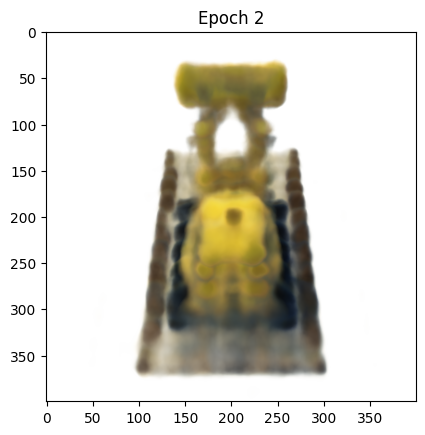

 30%|███       | 3/10 [01:54<04:27, 38.25s/it]

Loss: 209.4935
Loss: 208.8267
Loss: 199.3767
Loss: 217.1817
Loss: 206.4138
Loss: 195.8867
Loss: 223.2397
Loss: 207.9696
Loss: 203.1254
Loss: 217.2880
Loss: 206.1058
Loss: 235.6892
Loss: 223.9857
Loss: 218.2601
Loss: 224.9960
Loss: 198.2643
Loss: 192.3152
Loss: 210.8429
Loss: 196.9950
Loss: 226.4749
Loss: 213.0890
Loss: 216.0464
Loss: 215.8383
Loss: 219.3126
Loss: 212.3541
Loss: 226.9204
Loss: 198.0104
Loss: 216.9709
Loss: 214.3053
Loss: 208.5594
Loss: 206.4103
Loss: 218.1786
Loss: 205.1016
Loss: 216.9352
Loss: 218.2464
Loss: 206.8853
Loss: 207.4115
Loss: 205.8089
Loss: 219.0877
Loss: 212.2204
Loss: 201.9134
Loss: 211.2283
Loss: 215.2549
Loss: 203.3505
Loss: 215.0423
Loss: 210.1625
Loss: 221.5068
Loss: 207.1938
Loss: 203.3020
Loss: 212.2436
Loss: 229.4258
Loss: 205.5209
Loss: 202.6698
Loss: 213.6847
Loss: 197.8219
Loss: 204.9529
Loss: 226.5930
Loss: 224.3594
Loss: 213.4877
Loss: 203.0080
Loss: 197.0712
Loss: 202.3996
Loss: 209.9627
Loss: 202.8670
Loss: 210.3571
Loss: 209.9094
Loss: 218.

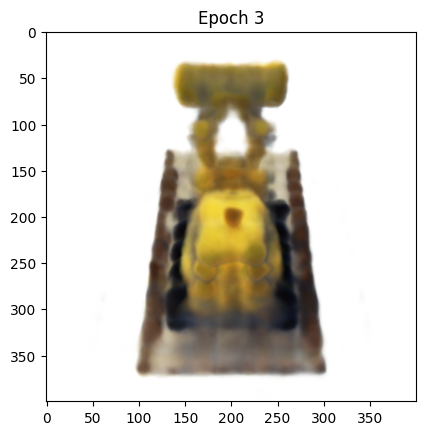

 40%|████      | 4/10 [02:33<03:49, 38.26s/it]

Loss: 204.1655
Loss: 202.3438
Loss: 204.2069
Loss: 198.8551
Loss: 201.8775
Loss: 190.5506
Loss: 205.7841
Loss: 191.4809
Loss: 201.6617
Loss: 198.9619
Loss: 191.5125
Loss: 196.6230
Loss: 191.3780
Loss: 207.3279
Loss: 191.6803
Loss: 193.9885
Loss: 192.6541
Loss: 182.4881
Loss: 174.7240
Loss: 200.9879
Loss: 198.1732
Loss: 179.1041
Loss: 195.6098
Loss: 197.1230
Loss: 208.5170
Loss: 184.0181
Loss: 203.4461
Loss: 190.4692
Loss: 192.2101
Loss: 185.4092
Loss: 190.2232
Loss: 182.0290
Loss: 193.4304
Loss: 186.3759
Loss: 199.9710
Loss: 194.2298
Loss: 193.5254
Loss: 198.5872
Loss: 192.9943
Loss: 187.3792
Loss: 191.1067
Loss: 191.1788
Loss: 189.9561
Loss: 201.8058
Loss: 189.8020
Loss: 183.6549
Loss: 196.0688
Loss: 198.9742
Loss: 202.3405
Loss: 190.0572
Loss: 200.0878
Loss: 197.4223
Loss: 195.0524
Loss: 191.3461
Loss: 184.8407
Loss: 194.1488
Loss: 191.2336
Loss: 195.3802
Loss: 203.9419
Loss: 181.0091
Loss: 186.1528
Loss: 187.9245
Loss: 191.6697
Loss: 192.4281
Loss: 181.3465
Loss: 179.8473
Loss: 191.

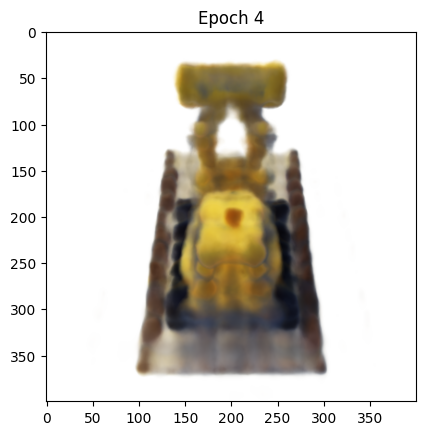

 50%|█████     | 5/10 [03:11<03:11, 38.24s/it]

Loss: 209.8174
Loss: 177.5313
Loss: 182.9450
Loss: 189.2127
Loss: 178.1028
Loss: 187.8658
Loss: 190.0413
Loss: 189.7937
Loss: 183.9940
Loss: 194.2806
Loss: 183.9801
Loss: 186.1010
Loss: 179.5052
Loss: 204.2122
Loss: 199.3086
Loss: 184.8510
Loss: 193.2486
Loss: 198.7654
Loss: 173.2779
Loss: 182.9364
Loss: 179.3658
Loss: 183.2341
Loss: 183.6674
Loss: 182.9663
Loss: 173.1320
Loss: 185.6317
Loss: 185.1968
Loss: 202.7822
Loss: 198.7216
Loss: 198.7308
Loss: 203.1593
Loss: 188.3204
Loss: 181.0380
Loss: 191.9659
Loss: 182.4948
Loss: 185.8070
Loss: 176.9494
Loss: 182.1890
Loss: 175.3134
Loss: 185.8766
Loss: 194.7166
Loss: 182.9847
Loss: 198.9751
Loss: 181.3913
Loss: 180.6691
Loss: 181.4475
Loss: 182.3155
Loss: 178.0761
Loss: 188.6012
Loss: 173.1663
Loss: 184.4179
Loss: 182.5113
Loss: 185.9057
Loss: 189.6161
Loss: 183.2183
Loss: 179.5726
Loss: 184.4006
Loss: 191.1315
Loss: 172.5606
Loss: 177.4764
Loss: 181.1256
Loss: 187.0257
Loss: 176.3847
Loss: 180.8046
Loss: 182.9854
Loss: 200.0174
Loss: 178.

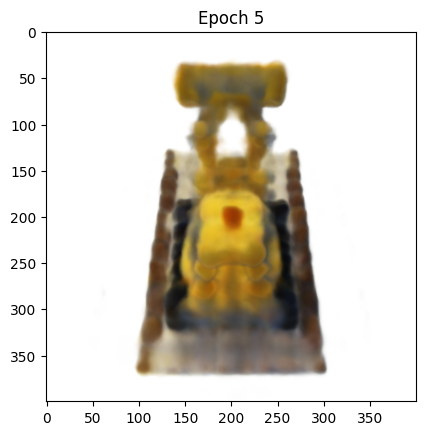

 60%|██████    | 6/10 [03:49<02:33, 38.28s/it]

Loss: 184.2940
Loss: 192.4369
Loss: 187.5372
Loss: 180.5587
Loss: 184.9293
Loss: 174.3713
Loss: 185.5347
Loss: 176.1246
Loss: 188.1744
Loss: 186.6805
Loss: 179.2126
Loss: 176.5243
Loss: 176.4625
Loss: 179.5287
Loss: 176.7995
Loss: 179.8842
Loss: 185.6449
Loss: 163.5664
Loss: 175.2672
Loss: 172.0302
Loss: 181.3509
Loss: 189.8483
Loss: 170.7771
Loss: 180.8893
Loss: 190.4635
Loss: 183.3278
Loss: 179.7188
Loss: 180.8837
Loss: 173.5302
Loss: 189.2410
Loss: 191.9403
Loss: 181.0294
Loss: 186.4400
Loss: 183.4249
Loss: 180.6107
Loss: 168.1683
Loss: 197.7076
Loss: 180.3294
Loss: 197.1211
Loss: 171.3032
Loss: 187.1789
Loss: 186.0351
Loss: 171.5180
Loss: 183.8664
Loss: 174.3717
Loss: 175.2325
Loss: 175.1745
Loss: 191.2591
Loss: 180.3814
Loss: 180.9789
Loss: 187.4784
Loss: 186.3637
Loss: 183.6124
Loss: 182.3606
Loss: 196.6858
Loss: 184.7155
Loss: 184.7893
Loss: 181.9887
Loss: 194.3106
Loss: 183.9095
Loss: 177.0977
Loss: 183.8658
Loss: 193.2357
Loss: 176.1898
Loss: 204.6380
Loss: 181.9587
Loss: 180.

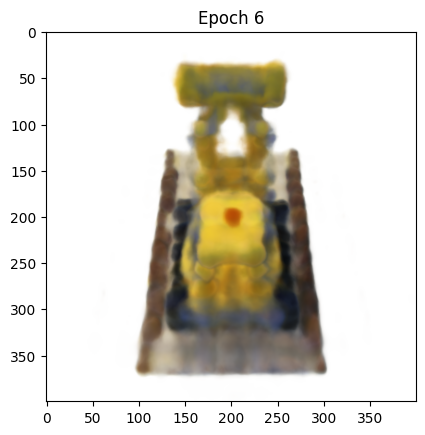

 70%|███████   | 7/10 [04:27<01:54, 38.25s/it]

Loss: 176.0235
Loss: 172.7427
Loss: 186.9546
Loss: 169.6174
Loss: 184.9866
Loss: 170.4909
Loss: 175.3731
Loss: 179.0772
Loss: 169.4840
Loss: 169.0639
Loss: 179.4099
Loss: 183.1091
Loss: 174.7099
Loss: 168.4853
Loss: 183.5649
Loss: 178.6435
Loss: 192.8378
Loss: 174.0431
Loss: 155.0931
Loss: 212.6037
Loss: 181.1553
Loss: 181.4629
Loss: 160.7150
Loss: 179.2192
Loss: 173.6553
Loss: 175.0977
Loss: 165.4658
Loss: 180.0127
Loss: 181.3342
Loss: 191.8866
Loss: 186.4771
Loss: 167.2145
Loss: 179.9753
Loss: 183.7395
Loss: 177.7041
Loss: 183.0043
Loss: 169.6972
Loss: 180.9026
Loss: 175.9928
Loss: 185.3586
Loss: 182.2383
Loss: 178.9369
Loss: 176.7627
Loss: 166.6534
Loss: 172.7435
Loss: 163.7607
Loss: 174.4617
Loss: 178.1533
Loss: 170.1263
Loss: 174.4918
Loss: 185.9884
Loss: 173.7246
Loss: 185.0544
Loss: 191.4766
Loss: 183.5090
Loss: 168.0924
Loss: 174.1459
Loss: 180.7652
Loss: 188.7865
Loss: 173.5959
Loss: 174.2012
Loss: 171.1604
Loss: 185.3797
Loss: 167.3593
Loss: 176.0275
Loss: 189.0686
Loss: 182.

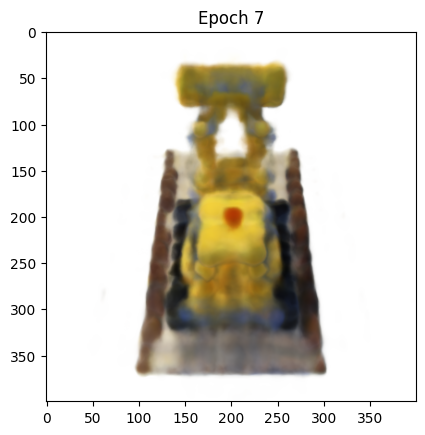

 80%|████████  | 8/10 [05:06<01:16, 38.27s/it]

Loss: 165.1185
Loss: 186.7729
Loss: 168.7848
Loss: 157.7342
Loss: 173.3441
Loss: 173.3118
Loss: 168.6884
Loss: 162.5448
Loss: 181.2315
Loss: 172.8939
Loss: 172.2430
Loss: 155.2692
Loss: 162.1834
Loss: 177.0616
Loss: 171.5658
Loss: 168.7416
Loss: 175.0616
Loss: 171.6733
Loss: 175.8216
Loss: 173.2350
Loss: 168.6172
Loss: 157.1567
Loss: 170.4803
Loss: 170.6198
Loss: 164.4057
Loss: 166.8888
Loss: 158.2975
Loss: 163.2309
Loss: 161.1541
Loss: 166.5865
Loss: 181.2065
Loss: 170.8307
Loss: 166.1393
Loss: 166.2826
Loss: 168.8103
Loss: 165.7944
Loss: 172.8794
Loss: 162.7170
Loss: 164.5683
Loss: 171.9791
Loss: 168.1092
Loss: 152.8436
Loss: 167.5064
Loss: 168.9902
Loss: 159.7550
Loss: 165.1415
Loss: 169.5864
Loss: 172.8052
Loss: 163.5654
Loss: 167.0808
Loss: 163.5776
Loss: 161.7297
Loss: 165.3765
Loss: 156.6260
Loss: 172.4526
Loss: 170.9720
Loss: 168.1914
Loss: 176.8376
Loss: 168.0901
Loss: 166.5280
Loss: 168.7714
Loss: 155.9807
Loss: 183.8139
Loss: 157.2521
Loss: 177.0794
Loss: 159.5264
Loss: 187.

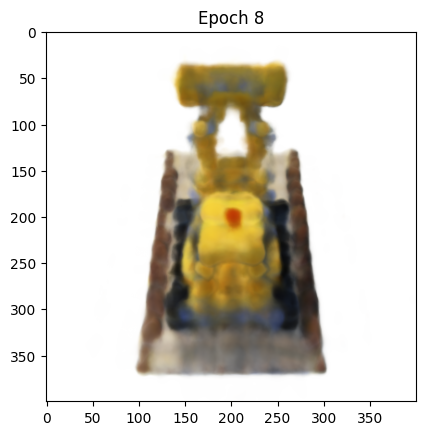

 90%|█████████ | 9/10 [05:44<00:38, 38.24s/it]

Loss: 164.6748
Loss: 164.9801
Loss: 168.5470
Loss: 166.9861
Loss: 167.3933
Loss: 174.2973
Loss: 167.7873
Loss: 157.0160
Loss: 160.1670
Loss: 168.6198
Loss: 163.7862
Loss: 170.2082
Loss: 168.1813
Loss: 168.7953
Loss: 159.9877
Loss: 174.6021
Loss: 163.2379
Loss: 162.2917
Loss: 169.6041
Loss: 156.4275
Loss: 164.1318
Loss: 174.0385
Loss: 164.2377
Loss: 155.2578
Loss: 173.4999
Loss: 172.8020
Loss: 166.1494
Loss: 167.0910
Loss: 166.1806
Loss: 170.5688
Loss: 173.1756
Loss: 178.1876
Loss: 162.2090
Loss: 164.5927
Loss: 175.7346
Loss: 172.3408
Loss: 166.2162
Loss: 154.1561
Loss: 164.0080
Loss: 160.4974
Loss: 179.3981
Loss: 173.7910
Loss: 170.4348
Loss: 164.5995
Loss: 171.3498
Loss: 159.2614
Loss: 160.5196
Loss: 163.2498
Loss: 175.4474
Loss: 174.3209
Loss: 167.9289
Loss: 161.5178
Loss: 166.5730
Loss: 170.0895
Loss: 155.4688
Loss: 162.7865
Loss: 153.0904
Loss: 159.1781
Loss: 160.4842
Loss: 165.2100
Loss: 167.4144
Loss: 165.0397
Loss: 169.5508
Loss: 164.3727
Loss: 177.4191
Loss: 181.7214
Loss: 168.

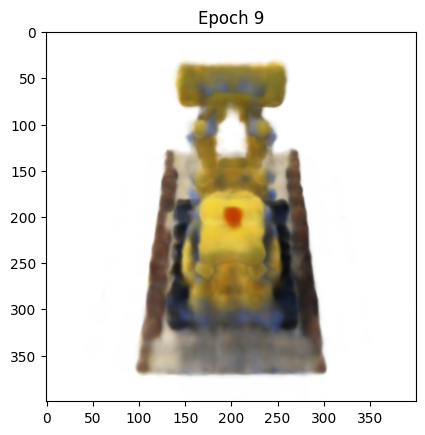

100%|██████████| 10/10 [06:22<00:00, 38.28s/it]


In [ ]:
device = 'cuda'
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
downscaled_data = training_dataset.reshape([100, 400, 400, 9])[..., ::4, ::4, 0:9].flatten(end_dim=-2)
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
model = NeRFModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5)
data_loader = DataLoader(downscaled_data, batch_size=8*1024, shuffle=True)
print(f" ")
loss, test_images = train(model, model_optimizer, scheduler, data_loader, testing_dataset, nb_epochs=10, device=device, hn=2, hf=6, nb_bins=32, H=400, W=400)

In [ ]:
def plot_images(images, grid = (2,5), titles=None, figsize=(20, 8)):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=figsize)

    for idx, (ax, img) in enumerate(zip(axes.flat, images)):
        ax.imshow(img)
        ax.axis('off')

        if titles is not None and idx < len(titles):
            ax.set_title(titles[idx])

    plt.tight_layout()
    plt.show()

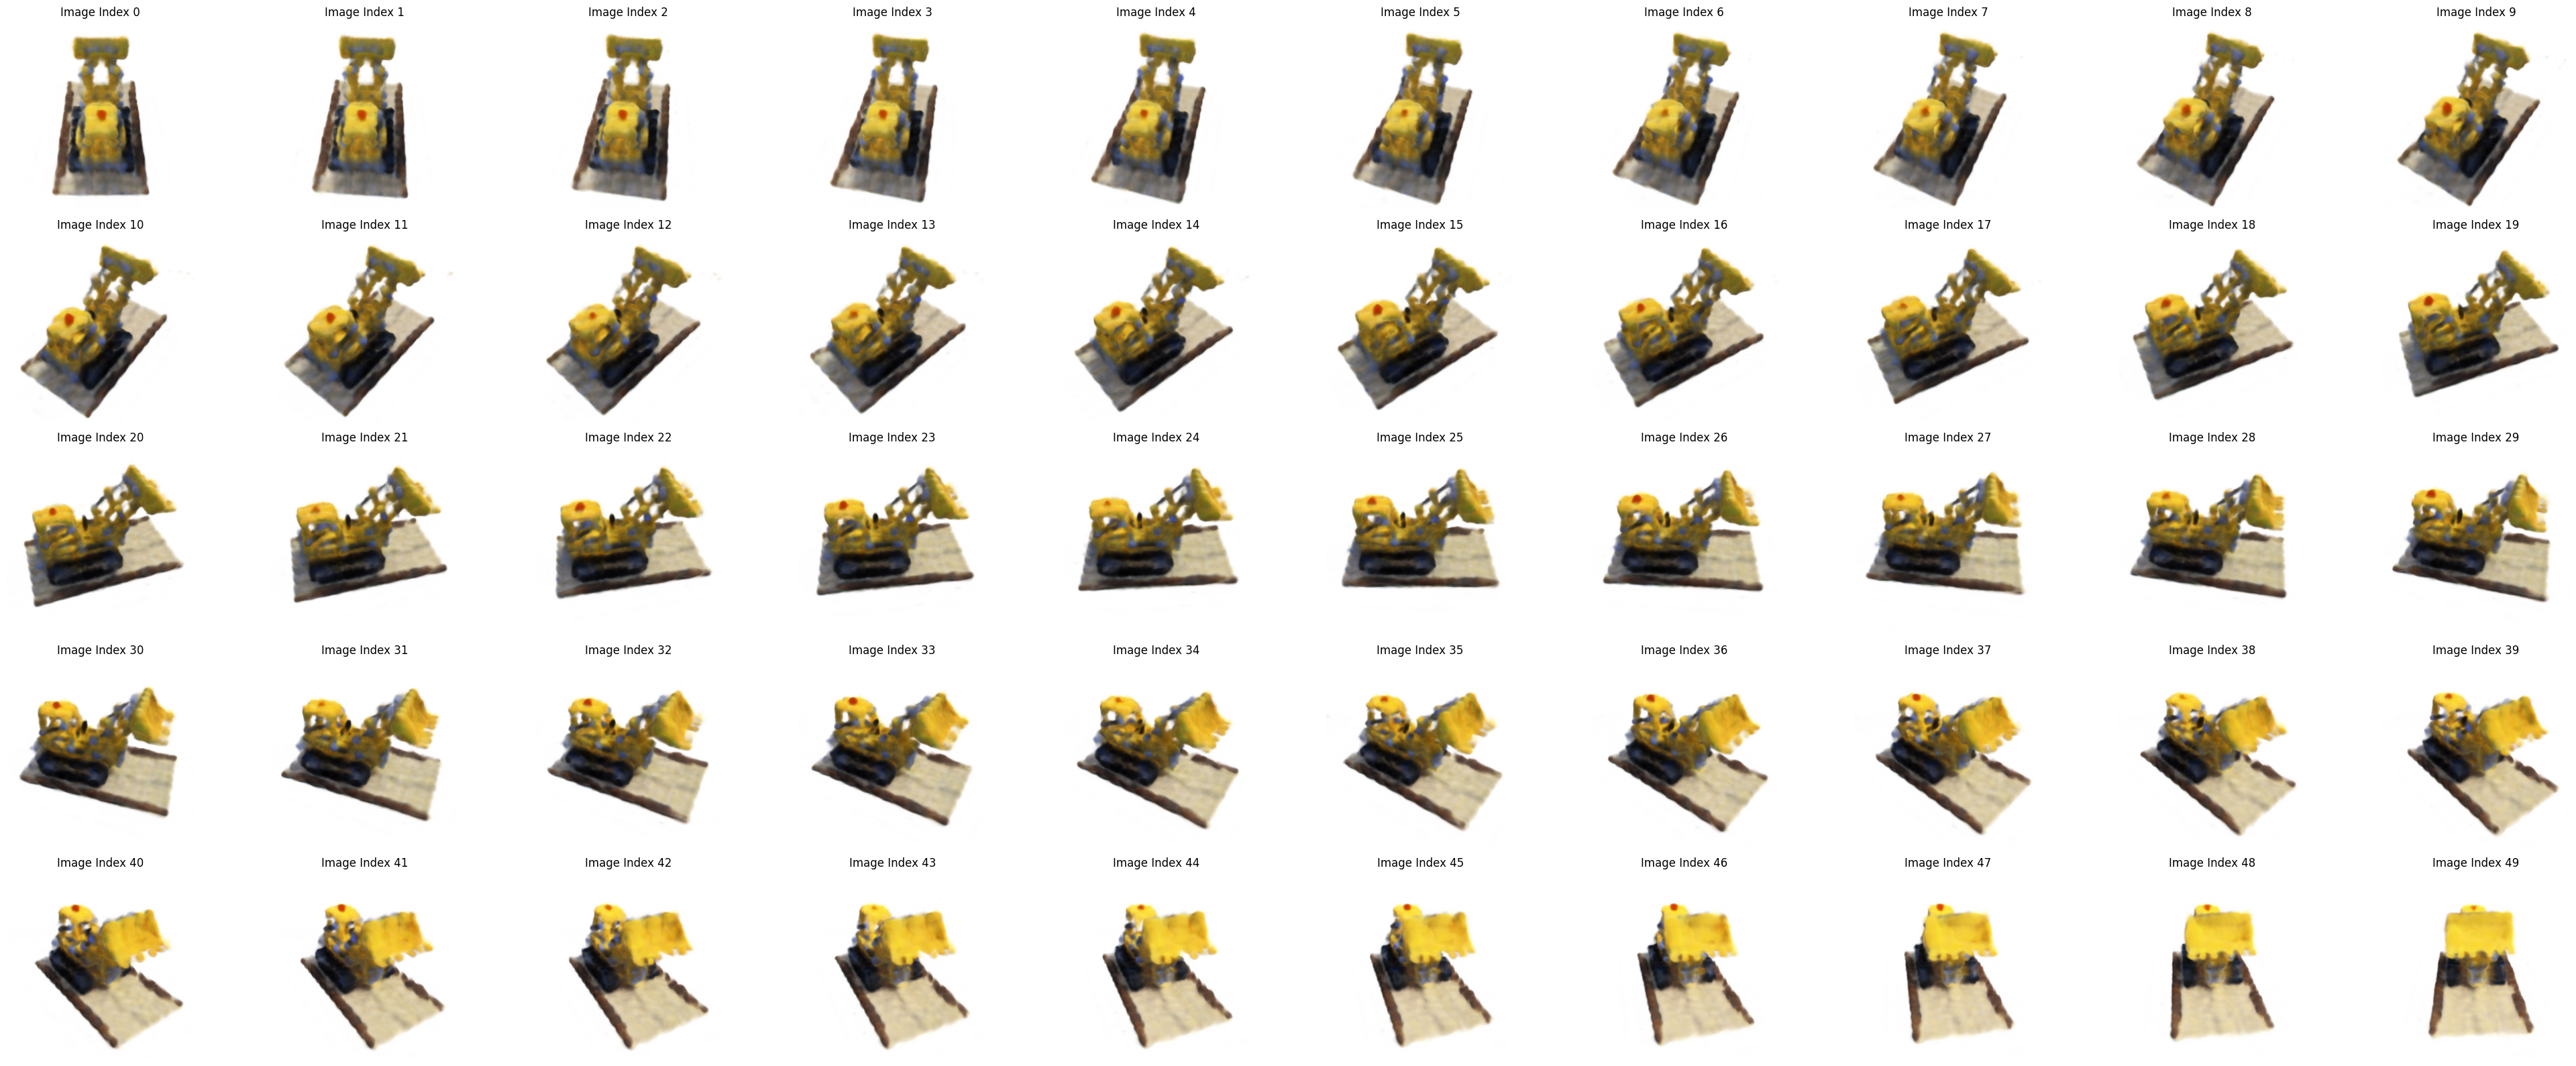

In [ ]:
images = []
for i in range(0, 50):
    img = test(model, testing_dataset, img_index=i, hn=2, hf=6, nb_bins=32, device=device, H=400, W=400)
    images.append(img)
titles = [f"Image Index {i}" for i in range(50)]
plot_images(images,(5, 10), titles, figsize=(40, 16))